**<h2>1. 데이터 전처리</h2>**

In [71]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [72]:
df = pd.read_csv('/content/sample_data/potato_weather.csv', index_col=0)
df = df.dropna(axis=0)
df = df.reset_index(drop=True)
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfWeek'] = df['Date'].dt.dayofweek

In [73]:
df['DayOfWeek'] = df['DayOfWeek'].astype('category')
df = pd.get_dummies(df, columns =['DayOfWeek'], prefix='W', drop_first=True)

In [74]:
df.tail()

,Date,Rain,Wind,Sup,Temp,Oil,sobimul,nongmul,Price,Avg_Price,W_1,W_2,W_3,W_4
2390,2022-09-26,0.0,1.7,58.5,20.0,1889.31,2.5,8.7,415.0,486.0,0,0,0,0
2391,2022-09-27,0.0,1.6,59.0,20.9,1889.31,2.5,8.7,415.0,491.0,1,0,0,0
2392,2022-09-28,0.0,1.8,71.0,20.4,1889.31,2.5,8.7,415.0,496.0,0,1,0,0
2393,2022-09-29,0.0,1.4,73.5,20.4,1889.31,2.5,8.7,415.0,498.0,0,0,1,0
2394,2022-09-30,0.0,1.6,68.0,20.7,1889.31,2.5,8.7,415.0,484.0,0,0,0,1


Text(0.5, 1.0, 'Avg_Price')

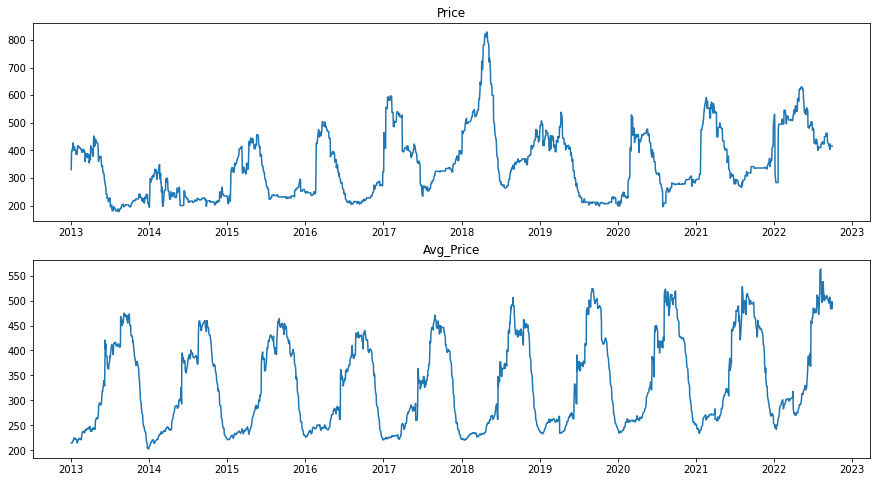

In [75]:
fig, axes = plt.subplots(2, 1, figsize=(15,8))
axes[0].plot(df['Date'], df['Price'])
axes[0].set_title('Price')
axes[1].plot(df['Date'], df['Avg_Price'])
axes[1].set_title('Avg_Price')

In [87]:
train_split_idx = 2211
window_size = 21
future = 1 # 오늘이 안들어오는 것을 대비해서, 어제부터 21개로 내일을 예측함 

In [88]:
x_train = df.iloc[:train_split_idx - window_size - future, 0:]
y_train = df.iloc[window_size + future:train_split_idx,[8]]

In [91]:
test_start = train_split_idx - window_size - future
test_end = df.shape[0] - window_size - future

In [92]:
x_test = df.iloc[test_start:test_end, 0:]
y_test = df.iloc[train_split_idx:, [8]]

In [100]:
x_train_scaled = x_train.loc[:, 'Rain':]
x_test_scaled = x_test.loc[:, 'Rain':]

In [101]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x_train_scaled.values)
x_train_scaled.loc[:,:] = scaler.transform(x_train_scaled.values)
x_test_scaled.loc[:,:] = scaler.transform(x_test_scaled.values)

In [103]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
train_data = timeseries_dataset_from_array(x_train_scaled, y_train, sequence_length=window_size, batch_size=1)
test_data = timeseries_dataset_from_array(x_test_scaled, y_test, sequence_length=window_size, batch_size=1)

In [105]:
for batch in test_data.take(1):
  inputs, targets = batch

print("Input", inputs.numpy().shape)
print("Target:", inputs.numpy().shape)

Input (1, 21, 13)
Target: (1, 21, 13)


**<h2>2. LSTM 모델 만들기</h2>**

In [122]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow import keras

model = Sequential()
model.add(LSTM(32, batch_input_shape=(1, 21, 13), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation='linear'))

In [123]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (1, 32)                   5888      
                                                                 
 dropout (Dropout)           (1, 32)                   0         
                                                                 
 dense_3 (Dense)             (1, 1)                    33        
                                                                 
Total params: 5,921
Trainable params: 5,921
Non-trainable params: 0
_________________________________________________________________


In [124]:
# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [125]:
from tensorflow.keras.callbacks import EarlyStopping
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [ ]:
num_epochs = 2000
history = LossHistory()
history.init()

for epoch_idx in range(num_epochs):
  print('epochs:' + str(epoch_idx))
  model.fit(train_data, validation_data=test_data, epochs=1, batch_size=1, verbose=2, shuffle=False, callbacks=[history, early_stopping_cb, checkpoint_cb])
  model.reset_states()

epochs:0
2169/2169 - 14s - loss: 99353.7734 - mae: 294.5329 - val_loss: 186052.1406 - val_mae: 423.9383 - 14s/epoch - 7ms/step
epochs:1
2169/2169 - 12s - loss: 70294.4141 - mae: 239.9594 - val_loss: 145332.1250 - val_mae: 372.8321 - 12s/epoch - 6ms/step
epochs:2
2169/2169 - 12s - loss: 49325.8672 - mae: 190.5860 - val_loss: 112269.0859 - val_mae: 325.4852 - 12s/epoch - 6ms/step
epochs:3
2169/2169 - 13s - loss: 34460.7070 - mae: 146.5352 - val_loss: 86159.2109 - val_mae: 282.5432 - 13s/epoch - 6ms/step
epochs:4
2169/2169 - 13s - loss: 25049.8574 - mae: 114.6696 - val_loss: 66807.2109 - val_mae: 245.9247 - 13s/epoch - 6ms/step
epochs:5
2169/2169 - 15s - loss: 19260.6641 - mae: 99.5897 - val_loss: 53438.9023 - val_mae: 217.0495 - 15s/epoch - 7ms/step
epochs:6
2169/2169 - 12s - loss: 16555.8477 - mae: 94.5771 - val_loss: 44773.5430 - val_mae: 197.3283 - 12s/epoch - 6ms/step
epochs:7
2169/2169 - 13s - loss: 15522.5859 - mae: 94.6194 - val_loss: 39794.8281 - val_mae: 185.6538 - 13s/epoch - 6